In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
##################################################################################################

In [2]:
# Load data
# census data from data.gov 
df = pd.read_excel("PUF2023.xlsx")
print("Initial Shape: ", df.shape)
df.head()
##################################################################################################

Initial Shape:  (6017, 28)


,weight,status,FINALDEST,FOOTINGS,LEASE,LOCATION,REGION,PIERS,SECURED,TITLED,...,jprice,jsqft,jbedroom,jlease,jfinaldest,jtitle,jsecured,jlocation,jfootings,jpiers
0,47.3929,2,1,3,2,2,3,1,1,2,...,I,I,I,I,I,I,I,I,I,I
1,47.3929,2,1,3,2,2,3,1,1,2,...,R,R,R,R,R,R,R,R,R,R
2,47.3929,1,1,3,2,2,3,1,1,2,...,I,I,I,I,I,I,I,I,I,I
3,47.3929,2,1,4,2,2,3,1,1,2,...,I,I,I,I,I,I,I,I,I,I
4,47.3929,2,1,5,2,2,3,1,1,2,...,R,R,R,R,R,R,R,R,R,R


In [3]:
df.dtypes
##################################################################################################

weight        float64
status          int64
FINALDEST       int64
FOOTINGS        int64
LEASE           int64
LOCATION        int64
REGION          int64
PIERS           int64
SECURED         int64
TITLED          int64
SECTIONS        int64
PRICE           int64
SQFT            int64
BEDROOMS        int64
SHIPMONTH       int64
WGTADJ        float64
CONTROL         int64
jstatus        object
jprice         object
jsqft          object
jbedroom       object
jlease         object
jfinaldest     object
jtitle         object
jsecured       object
jlocation      object
jfootings      object
jpiers         object
dtype: object

In [4]:
# Data cleaning
# Drop duplicate/redundant columns
df = df.drop(columns=df.filter(regex='^j').columns)

# Map categorical variables to readable labels
location_map = {1: 'Urban', 2: 'Suburban', 3: 'Rural'}
region_map = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}
titled_map = {1: 'Vehicle', 2: 'Land-Home', 3: 'Other'}

df['LOCATION'] = df['LOCATION'].map(location_map)
df['REGION'] = df['REGION'].map(region_map)
df['TITLED'] = df['TITLED'].map(titled_map)

# Convert LEASE to binary
df['LEASE'] = df['LEASE'].replace({2: 0, 1: 1})

# Handle missing values, fill missing values with median
num_cols = ['PRICE', 'SQFT', 'BEDROOMS']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Filter outliers
df = df[(df['PRICE'] > 10000) & (df['PRICE'] < 1e6)]
df = df[(df['SQFT'] > 100) & (df['SQFT'] < 5000)]

################################################################################
#Test



In [6]:
# Feature engineering
useful_cols = ['PRICE', 'SQFT', 'BEDROOMS', 'LOCATION', 'REGION', 'TITLED', 'LEASE', 'FOOTINGS']
sub_df = df[useful_cols].copy()

# add price per square foot
sub_df['PRICE_PER_SQFT'] = sub_df['PRICE'] / sub_df['SQFT']

# One hot encode categorical variables
sub_df_encoded = pd.get_dummies(sub_df, columns=['LOCATION', 'REGION', 'TITLED', 'FOOTINGS'])
################################################################################ 

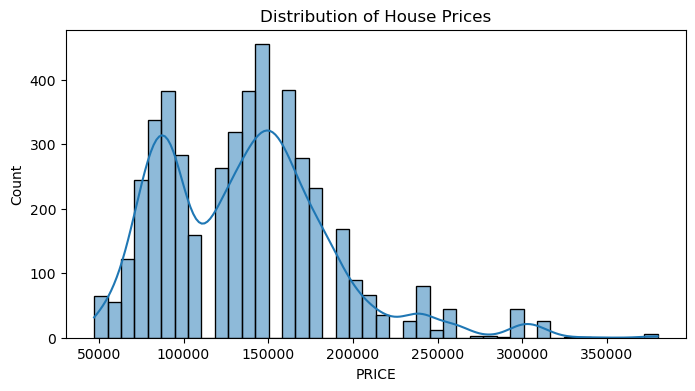

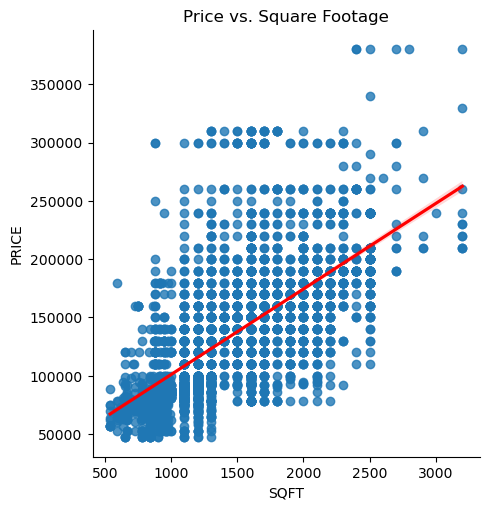

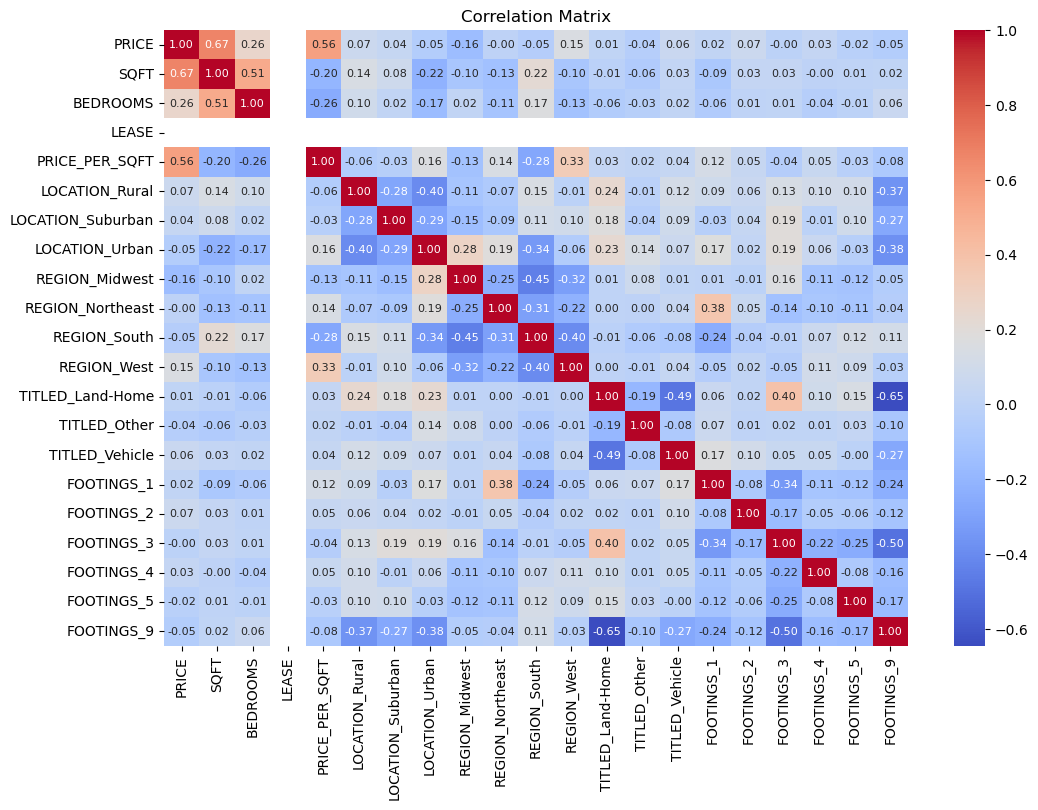

In [7]:
# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(sub_df['PRICE'], kde=True)
plt.title('Distribution of House Prices')
plt.show()

# Price vs Square Footage
sns.lmplot(x='SQFT', y='PRICE', data=sub_df, line_kws={'color': 'red'})
plt.title('Price vs. Square Footage')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
corr = sub_df_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})
plt.title('Correlation Matrix')
plt.show()
################################################################################

In [8]:
correlation_matrix = sub_df_encoded.corr()
print(correlation_matrix)
################################################################################

                      PRICE      SQFT  BEDROOMS  LEASE  PRICE_PER_SQFT  \
PRICE              1.000000  0.667828  0.256226    NaN        0.558413   
SQFT               0.667828  1.000000  0.513063    NaN       -0.201826   
BEDROOMS           0.256226  0.513063  1.000000    NaN       -0.257898   
LEASE                   NaN       NaN       NaN    NaN             NaN   
PRICE_PER_SQFT     0.558413 -0.201826 -0.257898    NaN        1.000000   
LOCATION_Rural     0.072820  0.138879  0.096074    NaN       -0.056239   
LOCATION_Suburban  0.036419  0.084807  0.020206    NaN       -0.033021   
LOCATION_Urban    -0.051395 -0.221089 -0.166182    NaN        0.164066   
REGION_Midwest    -0.157607 -0.104968  0.020701    NaN       -0.129828   
REGION_Northeast  -0.000174 -0.131941 -0.114249    NaN        0.141208   
REGION_South      -0.047500  0.217472  0.169489    NaN       -0.276344   
REGION_West        0.154038 -0.101263 -0.125344    NaN        0.333028   
TITLED_Land-Home   0.011241 -0.012653 

In [9]:
# Train test split
X = sub_df_encoded.drop('PRICE', axis=1)
y = sub_df_encoded['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("R2 Score:", r2_score(y_test, preds))
################################################################################


LinearRegression Performance:
MAE: 7091.704458085555
RMSE: 12472.95161722124
R2 Score: 0.9425813392155434

RandomForest Performance:
MAE: 1172.6192560175054
RMSE: 6272.5411450029505
R2 Score: 0.9854788296227543

XGBoost Performance:
MAE: 926.5068359375
RMSE: 4601.07335303405
R2 Score: 0.9921867251396179


In [10]:
# Define parameter grid
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# GridSearchCV
grid = GridSearchCV(XGBRegressor(random_state=42), param_grid=params, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_xgb = grid.best_estimator_
best_preds = best_xgb.predict(X_test)
print("\nBest XGBoost R2 Score:", r2_score(y_test, best_preds))
print("Best Parameters:", grid.best_params_)
################################################################################


Best XGBoost R2 Score: 0.9911962151527405
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [11]:
# Cross validation for RandomForest
cv_scores = cross_val_score(RandomForestRegressor(random_state=42), X, y, cv=5, scoring='r2')
print("\nRandomForest CV R2 Scores:", cv_scores)
print("Mean CV R2:", np.mean(cv_scores))
################################################################################


RandomForest CV R2 Scores: [0.99524755 0.99269613 0.99664477 0.99556662 0.99550756]
Mean CV R2: 0.9951325255931109


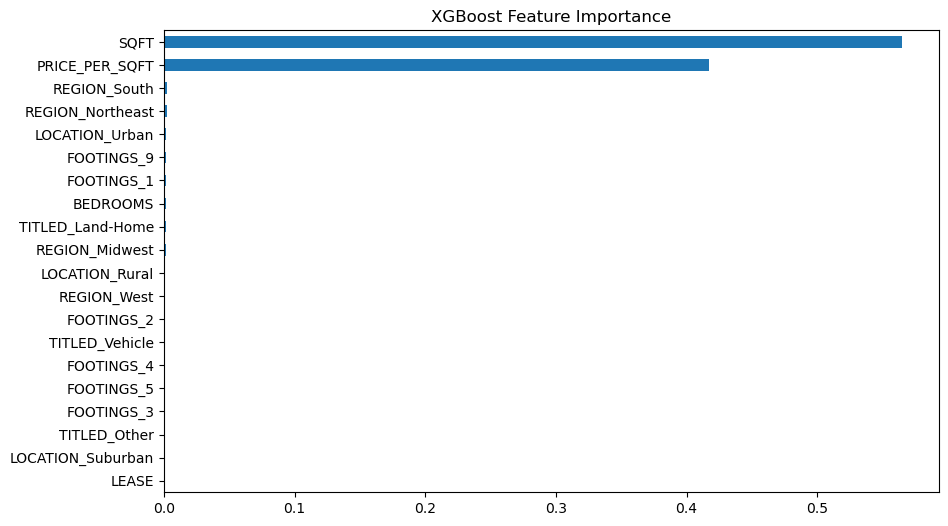

In [12]:
# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.show()
################################################################################